<a href="https://colab.research.google.com/github/heesukjang/W266_NLP_With_DeepLearning/blob/main/HW2_Text_classification_reference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Text Classification with Various Neural Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Deep Weighted Averaging Networks using Attention, and BERT-based models. You should also be able to develop an intuition for:


*   The effects of fine-tuning word vectors or starting with random word vectors
*   How various networks behave when the training set size changes
*   The effect of shuffling your training data
*   The benefits of Attention calculations
*   Working with BERT


The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

The initial part of the notebook is purely setup. We will then evaluate how Attention can make Deep Averaging networks better. 

Do not try to run this entire notebook on your GCP instance as the training of models requires a GPU to work in a timely fashion. This notebook should be run on a Google Colab leveraging a GPU. By default, when you open the notebook in Colab it will try to use a GPU. Total runtime of the entire notebook (with solutions and a Colab GPU) should be about 1h.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2023-spring-main/blob/master/assignment/a2/Text_classification.ipynb)

The overall assignment structure is as follows:


1. Setup
  
  1.1 Libraries, Embeddings,  & Helper Functions

  1.2 Data Acquisition

  1.3. Data Preparation

      1.3.1 Training/Test Sets using Word2Vec 

      1.3.2 Training/Test Sets for BERT-based models


2. Classification with various Word2Vec-based Models

  2.1 The Role of Shuffling of the Training Set

  2.2 DAN vs Weighted Averaging Models using Attention

    2.2.1 Warm-Up
    
    2.2.2 The WAN Model
    
  2.3 Approaches for Training of Embeddings 


3. Classification with BERT

  3.1. BERT Basics

  3.2 CLS-Token-based Classification 

  3.3 Averaging of BERT Outputs

  3.4. Adding a CNN on top of BERT



**INSTRUCTIONS:**: 

* Questions are always indicated as **QUESTION**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1.  Please do **not** remove the output from your notebooks when you submit them as we'll look at the output as well as your code for grading purposes.

* **### YOUR CODE HERE** indicates that you are supposed to write code.

* If you want to, you can run all of the cells in section 1 in bulk. This is setup work and no questions are in there. At the end of section 1 we will state all of the relevant variables that were defined and created in section 1.

* Finally, unless otherwise indicated your validation accuracy will be 0.65 or higher if you have correctly implemented the model.



## 1. Setup

### 1.1. Libraries and Helper Functions

This notebook requires the TensorFlow dataset and other prerequisites that you must download. 

In [3]:
#@title Installs

!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.2 MB/s eta 0:00:00


Now we are ready to do the imports.

In [4]:
# !pip list

In [5]:
# !pip install tensorflow==2.11.0
# !pip install numpy==1.21.5
# !pip install matplotlib==3.5.2
# !pip install pandas==1.4.4
# !pip install keras==2.11.0

In [6]:
#@title Imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim


Below is a helper function to plot histories.

In [7]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1, 
              model_history2, 
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric
        
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Next, we get the word2vec model from nltk.

In [8]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
word2vec_sample


[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


'/root/nltk_data/models/word2vec_sample/pruned.word2vec.txt'

Now here we have the embedding **model** defined, let's see how many words are in the vocabulary:

In [9]:
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)
len(model.vocab)

43981

What do the word vectors look like? As expected:

In [10]:
print(len(model['great']))
model['great'][:20]

300


array([ 0.0306035 ,  0.0886877 , -0.0121269 ,  0.0761965 ,  0.0566269 ,
       -0.0424702 ,  0.0410129 , -0.0497567 , -0.00364328,  0.0632889 ,
       -0.0142608 , -0.0791111 ,  0.0174877 , -0.0383064 ,  0.00926433,
        0.0295626 ,  0.0770293 ,  0.0949334 , -0.0428866 , -0.0295626 ],
      dtype=float32)

In [11]:
print(len(model['university']))
print(len(model.vocab.keys()))
print(model.vocab.keys())
print(list(model.vocab.items())[:2])
[val for val in list(model.vocab.values())[:2]]

300
43981
dict_keys(['fawn', 'deferment', 'Debts', 'Poetry', 'woods', 'clotted', 'hanging', 'hastily', 'comically', 'localized', 'spidery', 'disobeying', 'Adjusting', 'originality', 'Journey', 'mutinies', 'Western', 'alphabetic', 'Gravesend', 'Elec', 'slothful', 'wracked', 'Valle', 'Famed', 'stipulate', 'pigment', 'appropriation', 'rawhide', 'strictest', 'screaming', 'wooded', 'liaisons', 'broiler', 'wooden', 'Pergamon', 'Loeb', 'Sack', 'broiled', 'circuitry', 'deferments', 'resounds', 'Colonialism', 'gaskets', 'scrapes', 'precocity', 'Shocked', 'feasibility', 'miniatures', 'deadheads', 'mortgages', 'sustaining', 'consenting', 'Honorable', 'Pampa', 'scraped', 'snuggled', 'inanimate', 'errors', 'semicircular', 'tiered', 'Initially', 'cooking', 'Hamilton', 'outfielders', 'Niagara', 'hallucinating', 'succumb', 'shocks', 'crouch', 'chins', 'Foundation', 'jubilantly', 'zlotys', 'mailings', 'perforations', 'affiliates', 'perfunctorily', 'china', 'affiliated', 'Footnotes', 'confronts', 'doldr

We can now build the embedding matrix and a vocabulary dictionary:

In [12]:
#@title Embedding Matrix Creation

EMBEDDING_DIM = len(model['university'])      # we know... it's 300
print('EMBEDDING_DIM: ',EMBEDDING_DIM)
# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))  
print('\nembedding_matrix dim:',embedding_matrix.shape)   
print(embedding_matrix[:5])

vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    # print(f'i:{i} ; word:{word}')
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
print('\nlen(vocab_dict):',len(vocab_dict))
vocab_dict['[UNK]'] = len(vocab_dict)
print('Words: ', [k for k in list(vocab_dict.keys())[:10]])
print('Indexes: ',[v for v in list(vocab_dict.values())[:10]])

EMBEDDING_DIM:  300

embedding_matrix dim: (43982, 300)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

len(vocab_dict): 43981
Words:  ['fawn', 'deferment', 'Debts', 'Poetry', 'woods', 'clotted', 'hanging', 'hastily', 'comically', 'localized']
Indexes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [13]:
embedding_matrix.shape

(43982, 300)

In [14]:
embedding_matrix[:5, :5]   # first 5 rows and columns

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

In [15]:
embedding_matrix

array([[ 0.0891758 ,  0.121832  , -0.0671959 , ..., -0.0480419 ,
        -0.0277889 ,  0.0872918 ],
       [ 0.0526281 ,  0.013157  , -0.010104  , ...,  0.0209349 ,
        -0.0537912 ,  0.0654217 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 , ..., -0.00832253,
        -0.00398034, -0.0825016 ],
       ...,
       [ 0.0887422 ,  0.0537124 ,  0.0467064 , ..., -0.0794009 ,
         0.0945805 , -0.0361975 ],
       [-0.011512  ,  0.0173624 , -0.0364862 , ..., -0.0425253 ,
         0.0231499 , -0.014217  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

The last row consists of all zeros. We will use that for the UNK token, the placeholder token for **unknown words.**

### 1.2 Data Acquisition


We will use the IMDB dataset delivered as part of the TensorFlow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [16]:
train_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'test[80%:]'),     # train/test split to 80%:20%
    as_supervised=True)

# Out of total 25,000 reviews, 20,000 (80%) is set to the train and 5,000 (20%) to the testing set
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEHG3AS/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEHG3AS/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEHG3AS/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


It is always highly recommended to look at the data. What do the records look like? Are they clean or do they contain a lot of cruft (potential noise)?

In [17]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [18]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

For convenience, in this assignment we will define a sequence length and only keep the examples that are longer than that length.  We do this so that we have records with a lot of signal to aide our classifier predictions.

In [19]:
MAX_SEQUENCE_LENGTH = 100

## 1.3. Data Preparation

### 1.3.1. Training/Test Sets for Word2Vec-based Models

First, we tokenize the data:

In [20]:
# HS
from nltk.tokenize import WhitespaceTokenizer
# tk = tf_text.WhitespaceTokenizer()
tk = WhitespaceTokenizer()
gfg = "GeeksforGeeks \nis\t for geeks"
geek = tk.tokenize(gfg)
print('geek: ',geek)

geek:  ['GeeksforGeeks', 'is', 'for', 'geeks']


In [21]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

print('train_tokens[:2]:', train_tokens[:2])

train_tokens[:2]: <tf.RaggedTensor [[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.', b"Don't",
  b'be', b'lured', b'in', b'by', b'Christopher', b'Walken', b'or',
  b'Michael', b'Ironside.', b'Both', b'are', b'great', b'actors,', b'but',
  b'this', b'must', b'simply', b'be', b'their', b'worst', b'role', b'in',
  b'history.', b'Even', b'their', b'great', b'acting', b'could', b'not',
  b'redeem', b'this', b"movie's", b'ridiculous', b'storyline.', b'This',
  b'movie', b'is', b'an', b'early', b'nineties', b'US', b'propaganda',
  b'piece.', b'The', b'most', b'pathetic', b'scenes', b'were', b'those',
  b'when', b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
  b'cases', b'for', b'revolutions.', b'Maria', b'Conchita', b'Alonso',
  b'appeared', b'phony,', b'and', b'her', b'pseudo-love', b'affair',
  b'with', b'Walken', b'was', b'nothing', b'but', b'a', b'pathetic',
  b'emotional', b'plug', b'in', b'a', b'movie', b'that', b'was', b'devoid',
  b'of', b'any', b'real',

In [22]:
train_examples[0]

<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">

Let's look at some tokens.  Does they look acceptable?

In [23]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

Next, we define a simple function that converts the tokens above into the appropriate word2vec index values.   

In [24]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    text_labels = []
    valid_example_list = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with unknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding
        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)
    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.  We need to convert all of the tokens in to their respective input ids.

In [25]:
train_input_ids = docs_to_vocab_ids(train_tokens)
test_input_ids = docs_to_vocab_ids(test_tokens)

train_input_labels = np.array(train_labels)
test_input_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  4999


Let's convince ourselves that the data looks correct. We expect the train data to be an array of integer ids and the labels to be an array of zeroes and ones (since we are learning a **binary classifier**).

In [26]:
train_input_ids[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958],
       [12139,  7841, 19666, 31757, 43981, 17853, 25745, 15445, 43981,
        19123, 35029, 16908, 21113, 21068, 43981, 43981,  5668, 43981,
        33456, 43981, 34554, 43981,  1200, 27498, 43981, 1880

In [27]:
train_input_labels[:4]

array([0, 0, 0, 1])

### 1.3.2. Training/Test Sets for BERT-based models

We already imported the BERT model and the Tokenizer libraries. Now, let's load the pretrained BERT model and tokenizer. Always make sure to load the tokenizer that goes with the model you're going to use.

Call pre-trained BERT model as follows. Not the large size, just **base size**. The **cased** means that it recognize upper and lowercase.

And we always try to **load the tokenizer and the model at the same time**. so we make sure we are using the same model-the same model key (= 'bert-base-cased') here.

In [28]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Next, we will preprocess our train and test data for use in the BERT model. We need to convert our documents into vocab IDs, like we did above with the Word2Vec vocabulary. But this time we'll use the BERT tokenizer, which has a different vocabulary specific to the BERT model we're going to use.

In [29]:
bert_tokenizer.tokenize('I am so busy every day')   # using .tokenizer() shows what the tokens are. Each of those words gets its own token.

['I', 'am', 'so', 'busy', 'every', 'day']

In [30]:
# 125 is common but 1253 is not so they chopped off the 3 and generated '##3' instead.

bert_tokenizer.tokenize('This tree is 1253 years old.')

['This', 'tree', 'is', '125', '##3', 'years', 'old', '.']

In [31]:
# 'Pneumonia' is split into 4 tokens: ['P', '##ne', '##um', '##onia']
bert_tokenizer.tokenize('Pneumonia can be very serious.')

['P', '##ne', '##um', '##onia', 'can', 'be', 'very', 'serious', '.']

Let's look at the first 3 of these: 
- The very 1st weight matrix is the **word embedding matrix (= word_embeddings = bert_model.weights[0])**
  - **28996 = vocab_size (num_tokens)** in the BERT model.
  - **768 = embedding size** of the BERT model. So all the layers throughout will have 768.
- The 2nd matrix is the **token_type_embeddings**
- The 3rd matrix is the **position_embeddings**

In [32]:
print(len(bert_model.weights))    # bert_model.weights = weight matrixes
bert_model.weights[0]
# bert_model.weights

199


<tf.Variable 'tf_bert_model/bert/embeddings/word_embeddings/weight:0' shape=(28996, 768) dtype=float32, numpy=
array([[-0.00054784, -0.04156886,  0.01308366, ..., -0.0038919 ,
        -0.0335485 ,  0.0149841 ],
       [ 0.01688265, -0.03106827,  0.0042053 , ..., -0.01474032,
        -0.03561099, -0.0036223 ],
       [-0.00057234, -0.02673604,  0.00803954, ..., -0.01002474,
        -0.0331164 , -0.01651673],
       ...,
       [-0.00643814,  0.01658491, -0.02035619, ..., -0.04178825,
        -0.049201  ,  0.00416085],
       [-0.00483562, -0.00267701, -0.02901638, ..., -0.05116647,
         0.00449265, -0.01177113],
       [ 0.03134822, -0.02974372, -0.02302896, ..., -0.01454749,
        -0.05249038,  0.02843569]], dtype=float32)>

In [33]:
bert_model.weights[1]

<tf.Variable 'tf_bert_model/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32, numpy=
array([[-3.6974233e-03,  1.7510093e-03, -1.4998456e-05, ...,
         4.1503753e-03, -4.3169265e-03,  2.5677346e-04],
       [-2.4836401e-03, -3.9493470e-03, -3.2805414e-03, ...,
        -2.4496014e-03, -2.2277145e-03, -2.3139343e-03]], dtype=float32)>

In [34]:
bert_model.weights[2]

<tf.Variable 'tf_bert_model/bert/embeddings/position_embeddings/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 0.02344714,  0.00516326, -0.013507  , ...,  0.00153387,
         0.01396566,  0.00978599],
       [-0.02690891, -0.00475334, -0.00550656, ...,  0.00586852,
         0.00464536, -0.00547428],
       [-0.01394941, -0.00832889,  0.00383158, ...,  0.00617752,
         0.00074595, -0.01051977],
       ...,
       [ 0.0049373 ,  0.01553355,  0.02107639, ..., -0.00957435,
         0.02251508,  0.01383893],
       [ 0.01732728, -0.02141069, -0.00283472, ..., -0.02397991,
        -0.00158155, -0.01289534],
       [ 0.00196406, -0.01695957,  0.00028094, ...,  0.00183421,
        -0.01463418, -0.00022347]], dtype=float32)>

After the 1st few maxtrixes, we just jump ahead to like the 20th matrix, we'll get into the **actual transformer blocks** with the **layer 0 (= layer_._0)** as follows so the transformer blocks will be numbered and the following is the **output** from that layer 0.

In [35]:
bert_model.weights[20]

<tf.Variable 'tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 3.03813405e-02, -1.15645550e-01, -3.58965695e-02, -3.28842364e-02,
        2.22262740e-03, -4.33451869e-02,  1.68459162e-01, -7.57162943e-02,
       -4.98437136e-02, -5.83802424e-02, -4.05814871e-03, -1.03552990e-01,
       -5.56561984e-02, -7.31328875e-02, -4.95285168e-02, -1.14453621e-01,
       -6.60634972e-03, -5.27041592e-02, -5.21052964e-02, -3.80412936e-02,
       -1.52273223e-01, -8.67277756e-02, -1.10466089e-02, -2.36845333e-02,
       -6.46511242e-02, -6.96847662e-02,  3.12845521e-02, -6.29114807e-02,
       -4.27780636e-02, -4.18336503e-02, -6.72229454e-02,  1.21081427e-01,
       -4.37419787e-02, -7.48900995e-02, -6.78982586e-02, -5.37771881e-02,
       -3.48127410e-02, -5.61586991e-02, -1.24133192e-01, -2.08051540e-02,
       -9.95275378e-02,  9.49560571e-03,  4.23747348e-03, -9.83619392e-02,
       -2.27580629e-02, -5.53368777e-02, -6.03646897e-02,  7.999

In [36]:
bert_model.weights[25]

<tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/self/value/kernel:0' shape=(768, 768) dtype=float32, numpy=
array([[ 1.9315634e-02,  4.1598234e-02, -1.6625568e-02, ...,
        -7.6039950e-03,  1.8319575e-02, -2.8726449e-03],
       [ 3.3757713e-02,  4.1080564e-02, -2.3961579e-02, ...,
         2.2693582e-02,  1.9539362e-02, -2.1245511e-02],
       [ 2.3454960e-02,  5.1831760e-02, -3.5314523e-02, ...,
         6.9972770e-03,  1.0493889e-02,  7.7483756e-03],
       ...,
       [-2.1094063e-02, -2.9417649e-02,  7.7335447e-02, ...,
        -1.9195084e-02,  7.4874978e-03,  3.8115731e-03],
       [ 8.5312594e-03, -3.1422116e-03,  1.5219791e-02, ...,
        -1.7956279e-02,  3.4414354e-04,  1.1326044e-02],
       [-4.7408726e-02, -4.5913399e-05,  2.7038001e-02, ...,
         1.1778945e-02, -2.6979292e-02, -1.6242245e-02]], dtype=float32)>

Ouch! Many more complex terms are not in BERT's vocabulary and are split up.

## Text Classification with BERT (using the Pooler Output)

The BERT model returns two values that can be exploited for classification purposes. One is the last_hidden_state which is the sequence of hidden-states at the output of the last layer of the model.  The second one is the pooler output, with is the output of the [CLS] token where another linear layer is added on top followed by a tanh. This pooler output can be used for classification purposes.

Let us create the data. More will be discussed in class. (We can limit the training and test data sizes for expedience in class.)

In [37]:
train_examples[:2]

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [38]:
train_examples[:2].numpy()

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

We need a list of tokens to give us vocab_ids (= input_ids). This is what we want for our model. the following will return a list of 3 things:
- **input_ids** = vocab_ids: 
  - \<CLS\>, vocab_id_1, vocab_id_2...\<SEP\>,\<pad\>...\<pad\>
  - i.e. [ **101(CLS)**, 1188 (vocab_id_1), 1108(vocab_id_2)...**102 (SEP)**, 0 (pad),...**0 (pad)**] ==> Truncate to max seq length
  - i.e. [ **101(CLS)**, 1188 (vocab_id_1), 1108(vocab_id_2)...**102 (SEP)**]  ==> Pad for the shorter seq
- **token_type_ids:** going to be all 0s in this notebook because we just have the simple text where all the words are all part of the the same thing. It's a **movie review**. If you had different parts, that's what this **token_type_ids** can be used for. For example, if you have 2 sentences and for the next sentence prediction task that BERT was also trained on. There are **0s for the 1st sentence** and **1s for the 2nd sentence** and you could even have like then **2s for the 3rd sentence**. In later weeks, we will talk about **question/answering** where you often have multiple different parts of the input.For example, if it's a multiple choice, here is **answer A** and here is **answer B**, etc. But right now, the input is all one thing.
- **attention_mask:** we will have
  - 1s for the real tokens
  - 0s for the padding

becasue then in each layer of the transformer, the it can't pay attention to the pattern tokens but only to the real tokens.

In [39]:
#@title BERT Tokenization of training and test data

train_examples_str = [x.decode('utf-8') for x in train_examples.numpy()]
test_examples_str = [x.decode('utf-8') for x in test_examples.numpy()]

bert_train_tokenized = bert_tokenizer(train_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

bert_test_tokenized = bert_tokenizer(test_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

In [40]:
bert_train_tokenized

{'input_ids': <tf.Tensor: shape=(20000, 100), dtype=int32, numpy=
array([[  101,  1188,  1108, ...,  1123, 23563,   102],
       [  101,   146,  1138, ...,  1133,   178,   102],
       [  101, 10852,  6810, ..., 16562,  1115,   102],
       ...,
       [  101, 10899,   117, ...,   163, 13041,   102],
       [  101,  1966,   146, ...,  1109,  1864,   102],
       [  101,  1188,   181, ...,  1107,  1385,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(20000, 100), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(20000, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype

In [41]:
# print(len(bert_train_inputs))
# bert_train_inputs[:10]

In [43]:
print(bert_train_labels)
bert_train_labels[:10]

[0 0 0 ... 0 0 0]


array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

Overall, here are the key variables and sets that we encoded for word2vec and BERT and that may be used moving forward. If the variable naming does not make it obvious, we also state the purpose:

#### Parameters:

* MAX_SEQUENCE_LENGTH (100)


#### Word2vec-based models:

* train(/test)_input_ids: input ids for the training(/test) sets for word2vec models
* train(/test)_input_labels: the corresponding labels

#### BERT:


* bert_train(/test)_inputs: list of input_ids, token_type_ids and attention_mask for the training(/test) sets for BERT models
* bert_train(/test)_labels: the corresponding labels for BERT

**NOTE:** We recommend you inspect these variables if you have not gone through the code.

## 2. Classification with various Word2Vec-based Models

**QUESTION:**

2.a. Revisit the dataset. Is it balanced? Find the percentage of positive examples in the training set. (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765): **Closely balanced**

In [44]:
print(type(train_input_labels))
print(len(np.where(train_labels==1)[0]))
print(len(np.where(train_input_labels==1)[0]))
print(len(train_labels))
print(len(train_input_labels))
print(train_input_labels.shape)
# test_labels

<class 'numpy.ndarray'>
9969
9969
20000
20000
(20000,)


In [45]:
### YOUR CODE HERE
count_pos = len(np.where(train_input_labels==1)[0])
perc_pos = np.round(count_pos/len(train_input_labels), 5)
print(f'Numer of positive samples = {count_pos}\nTotal number of data samples = {len(train_input_labels)}')
print(f'\nPositive Examples in the Training Set = {(perc_pos*100).round(5)}% ({perc_pos})')

### END YOUR CODE

Numer of positive samples = 9969
Total number of data samples = 20000

Positive Examples in the Training Set = 49.845% (0.49845)


**QUESTION:**

2.b. Now find the percentage of positive examples in the test set.  (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765)

In [46]:
### YOUR CODE HERE
count_pos = len(np.where(test_input_labels==1)[0])
perc_pos = np.round(count_pos/len(test_input_labels),5)
print(f'Numer of positive samples = {count_pos}\nTotal number of data samples = {len(test_input_labels)}')
print(f'\nPositive Examples in the Test Set = {(perc_pos*100).round(5)}% ({perc_pos})')

### END YOUR CODE

Numer of positive samples = 2513
Total number of data samples = 5000

Positive Examples in the Test Set = 50.26% (0.5026)


### 2.1 The Role of Shuffling of the Training Set


We will first revisit the DAN model. 

2. Reuse the code from the class notebook to build a DAN network with one hidden layer of dimension 100. The optimizer should be Adam. Wrap the model creation in a function according to this API:

unshuffled: 50%, shuffled: 75%
need only one hidden layer (1 layer with 100 neurons) pass "h_dim"=[100] => l layer with 100 nodes

In [47]:
def create_dan_model(retrain_embeddings=False, 
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec', 
                     learning_rate=0.001):
  """
  Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'

  
  ### YOUR CODE HERE

  # start by creating the dan_embedding_layer. Use the embeddings_initializer. variable defined above.

  # Input layer
  dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

  # Embedding layer
  dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer=embeddings_initializer,
                                  input_length=MAX_SEQUENCE_LENGTH,
                                  trainable=retrain_embeddings)
  dan_embeddings = dan_embedding_layer(dan_input_layer)

  # Average embedding layer
  dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                              name='averaging')(dan_embeddings)
  last_hidden_output = dan_avg_embeddings

  # Dense (fully-connected) layer
  last_hidden_output = tf.keras.layers.Dense(hidden_dim, activation='relu', name='dan_hidden_%d' % i)(last_hidden_output)

  # Dropout layer
  last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)
  
  # Output layer
  dan_classification = tf.keras.layers.Dense(1, activation='sigmoid', name='dan_classification')(last_hidden_output)
  
  # Model
  dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])

  # Model compile
  dan_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        amsgrad=False,
                                                        name='Adam'),
                    metrics='accuracy')

  ### END YOUR CODE
  return dan_model

  # Adam optimizer: gradient descent, forward pass and loss with back propagation, each of the node nerual netowk. 
  # each node calcualted gradient, depeding on the slop of the gradient, going down, adam helps move the gradient to the right direction.
  # learning rate

Let us create a sorted version of the training dataset to run our simulations:

In [48]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

print(sorted_training_input_ids)
print(sorted_training_labels)

[[21531 25272 12291 ... 36633  9483 42958]
 [12139  7841 19666 ... 14087  9370 33458]
 [ 9405 40803 14193 ... 43036 11511 43981]
 ...
 [15402 28743 38632 ... 43981 32026 14193]
 [23487 42375 43981 ... 43981 43981 43981]
 [21531 16908  2230 ... 19123 14193 19791]]
[0 0 0 ... 1 1 1]


Next, create your DAN model using the default parameters and train it by:

1.  Using the sorted dataset
2.  Using 'shuffle=False' as one of the model.fit parameters.
3.  Train for 10 epochs with a batch size of 32

Make sure you store the history (name it 'dan_sorted_history') as we did in the lesson notebooks. 



In [49]:
### YOUR CODE HERE

dan_model_sorted = create_dan_model()

dan_sorted_history = dan_model_sorted.fit(sorted_training_input_ids,
                                          sorted_training_labels,
                                          validation_data=(test_input_ids, test_input_labels),
                                          shuffle=False,
                                          batch_size=32,
                                          epochs=10)

#use dan_sorted_history = ... below
### END YOUR CODE                        

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3135 - accuracy: 0.9045 - val_loss: 2.7608 - val_accuracy: 0.5026
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6985 - accuracy: 0.7285 - val_loss: 1.6952 - val_accuracy: 0.5026
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6088 - accuracy: 0.7445 - val_loss: 1.3153 - val_accuracy: 0.5026
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5841 - accuracy: 0.7343 - val_loss: 1.3346 - val_accuracy: 0.5026
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5595 - accuracy: 0.7326 - val_loss: 1.7931 - val_accuracy: 0.5026
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6254 - accuracy: 0.7296 - val_loss: 1.2798 - val_accuracy: 0.5026
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5651 - accuracy: 0.7359 - val_loss: 1.4589 - val_accuracy: 0.5026
Epoch 

**QUESTION:**

2.1.a What is the highest validation accuracy that you observed after you completed the 10 epochs? (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765)

Hint: You should have an accuracy number above 0.30.



In [50]:
# print(round(dan_sorted_history.history['val_accuracy'][-1], 5))
print('The highest val_accuracy: {:.5f}'.format(max(dan_sorted_history.history['val_accuracy'])))

The highest val_accuracy: 0.50260


Next, recreate the same model and train it with **'shuffle=True'**. (Note that this is also the default.). Use 'dan_shuffled_history' for the history.

In [51]:
### YOUR CODE HERE

dan_model_shuffled = create_dan_model()       

dan_shuffled_history = dan_model_shuffled.fit(sorted_training_input_ids,
                                              sorted_training_labels,
                                              validation_data=(test_input_ids, test_input_labels),
                                              shuffle=True,
                                              batch_size=32,
                                              epochs=10)

#use dan_shuffled_history = ... below

### END YOUR CODE                        

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6389 - accuracy: 0.6559 - val_loss: 0.5947 - val_accuracy: 0.6914
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5498 - accuracy: 0.7294 - val_loss: 0.5406 - val_accuracy: 0.7274
Epoch 3/10
625/625 [==============================] - 3s 6ms/step - loss: 0.5183 - accuracy: 0.7469 - val_loss: 0.5237 - val_accuracy: 0.7426
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5065 - accuracy: 0.7535 - val_loss: 0.5155 - val_accuracy: 0.7506
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4984 - accuracy: 0.7584 - val_loss: 0.5158 - val_accuracy: 0.7508
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4922 - accuracy: 0.7599 - val_loss: 0.5042 - val_accuracy: 0.7546
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4887 - accuracy: 0.7626 - val_loss: 0.5061 - val_accuracy: 0.7574
Epoch 

**QUESTION:**

2.1.b What is the highest validation accuracy that you observed for the shuffled run after completing 10 epochs? (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765)


In [52]:
# print(round(dan_shuffled_history.history['val_accuracy'][-1], 5))
print('The highest val_accuracy: {:.5f}'.format(max(dan_shuffled_history.history['val_accuracy'])))

The highest val_accuracy: 0.75840


Compare the 2 histories in a plot.

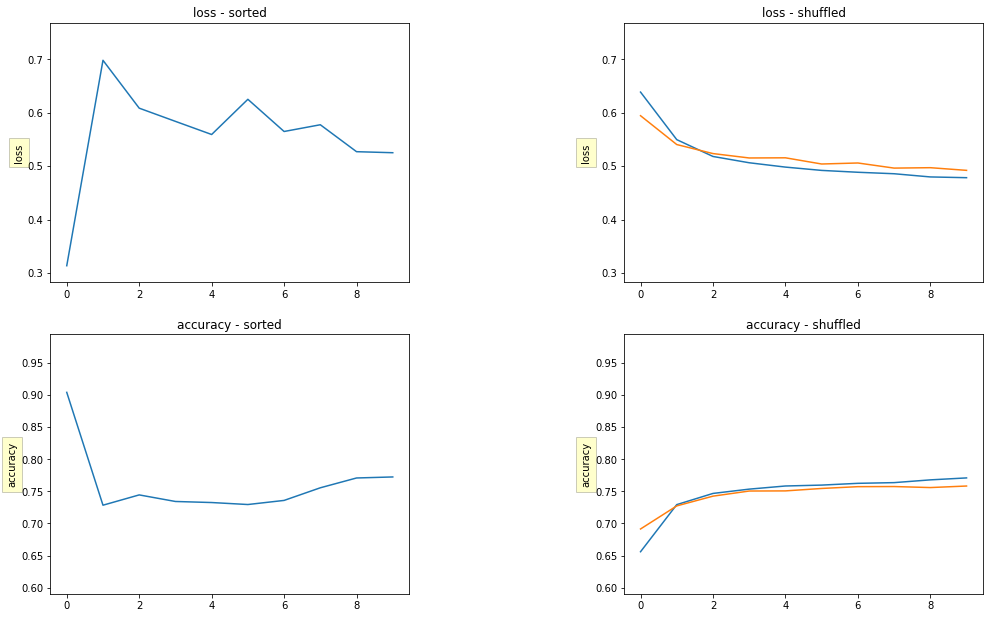

In [53]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_sorted_history,
          dan_shuffled_history, 
          model_1_name='sorted',
         model_2_name='shuffled')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
# plt.ylim([0.4, 1])
plt.show()

### 2.2 DAN vs Weighted Averaging Models using Attention 

#### 2.2.1. Warm-Up: Manual Attention Calculation

**QUESTION:**

2.2.1.a Calculate the context vector for the following query and key/value vectors. You can do this manually, or you can use 


```
tf.keras.layers.Attention()
```

2.2.1.b What are the weights for the key/value vectors?

HS: not rely on context prior
q = query vector to see if previous context are relevant or not, k=key vector, v=value vactor and k=v
if these two vectors are the same, they are similar. feed convex combination weights to softmax (non-linear: squash math) (prob-relative weights will be add up to 1)





In [54]:
from multiprocessing import Value
q = [1, 2., 1]

k1 = v1 = [-1, -1, 3.]
k2 = v2 = [1, 2, -5.]
# they are alwasy go together. in terms of search. google search, often have something possible items to return.
# match the doc to match.
# query is short
# then we might not title of the book key to match the uqery. ore match to the querydot product 
# similary score betweent he key and Valueapply weights to find value

In [55]:
### YOUR CODE HERE
query = np.array([q])
keys_values = np.array([k1, k2])
# print(query,'\n',keys_values)

tf.keras.layers.Attention()([query, keys_values], return_attention_scores=True)
### END YOUR CODE

# outputs  first output = prediction of movie review: weighted average vector (context vector) and then the 2nd output is the weights from attention layer

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0. ,  0.5, -1. ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5, 0.5]], dtype=float32)>)

#### 2.2.2 The 'WAN' Model


Next, we would like to improve our DAN by attempting to train a neural net that learns to put more weight on some words than others. How could we do that? **Attention** is the answer!

Here, we will build a model that you can call "Weighted Averaging Models using Attention". You should construct a network that uses attention to weight the input tokens for a given example.

The core structure is the same as for the DAN network, so remember to re-use the embedding matrix you initialized earlier with word2vec embedding weights.

However, there are obviously some critical changes from the DAN:

1) How do I create a learnable query vector for the attention calculation that is supposed to generate the suitable token probabilities? And what is its size?

2) What are the key vectors for the attention calculation?

3) How does the averaging change? 


First, the key vectors should be the incoming word vectors.

The query vector needs to have the size of the word vectors, as it needs to attend to them. A good way to create the query vector is to generate an embedding like vector easily by getting a single row of trained weights from a Dense layer if we pass in a value of one to multiply by that weight matrix in the usual way:


```
wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
```

That sounds great... but how do I use this to have a vector available in my calculation? And... make this vector available to all examples in the batch?

What you can use is a 'fake input-like layer' that creates for each incoming batch example a '1', that then the query layer can get applied to.
Assuming that the input layer for your network is **wan_input_layer**, this could be done with

```
wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1)) 
```

You could then have the query vector available for each example through:

```
wan_query_vector = wan_query_layer(wan_batch_of_ones)

```

You will see that this structure is essentially the same as what we did for word vectors, except that we had to replace the input layer with our fake layer, as there is no actual input. We will also have **2 outputs** (discussed in a bit.)

How does the averaging change? You should use:

```
tf.keras.layers.Attention()
```

and make sure you consider the proper inputs and outputs for that calculation.

So why 2 outputs, and how do we do that? First off, we need the output that makes the **classification**, as always. What is the second output? We also would like our model to provide us with the **attention weights** it calculated. This will tell us which words were considered how much for the context creation.

Can we implement 2 outputs? You need to have a list of the two outputs. But note that you may also want to have a list of **2 cost function and 2 metrics**. You can use **'None'** both times to account for our new second output, and you can ignore the corresponding values that the model report. (In general, the total loss will be a sum of the individual losses. So one would rather construct a loss that always returns zero for the second loss, but as it is very small we can ignore this here.)

Finally, you may want to **reshape the output after the Attention layer**, because the Attention layer will still give a sequence of vectors for each example. It will just be a sequence of one weighted average vector for each example. You may want to **remove that middle dimension of size one** so you just have a single vector for each example. You can do that with layers.Reshape():

```
wan_attention_output = tf.keras.layers.Reshape((wan_attention_output.shape[-1],))(wan_attention_output)
```

In [56]:
# reshape before sigmoid.
# needrelu activation (not required).
# candropout is not required

# attention
# flatten (reshape) what does that output look like? each sentence will have one line. the embeddings will return a list of embeddings
# add hidden layers with relu
# then dropout
# then output layer (input to the sigmoid)
# create a model with input layer, cla
# two matrix to be defined. need to pass metrics=['accuracy', None]
# model returns classifcation and weights and we need to return the 2nd one, weights.

# relu (dense)
# no need loop
# just last output
# model has two outputs (first output: context vector and weights
# whenever  and attention scores)

# first one(k1-1st token in the input): context vector and 2nd one(k2-2nd token in the input): weights
# 2nd and 3rd models: need to train only 3 epochs

In [57]:
def create_wan_model(retrain_embeddings=False, 
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001):
  """
  Construct the WAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'
  
  ### YOUR CODE HERE

  # Input layer
  wan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')

  # Generate query vector
  wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
  wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1))
  wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1]) 
  wan_query_vector = wan_query_layer(wan_batch_of_ones)
  
  # Embedding layer
  wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer=embeddings_initializer,
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings)
  
  wan_embeddings = wan_embedding_layer(wan_input_layer)

  # Attention layer: wan_attention_output (context vector-prediction) and attention_weights  => will use the output of this attention 
  wan_attention_output, attention_weights = tf.keras.layers.Attention()([wan_query_vector, wan_embeddings], return_attention_scores=True)

  # Reshape (flatten) layer: Convert a sequence of vectors for each example (None, 1, 300) to a sequence of one weighted average vector for each example (None, 300)
  wan_attention_output = tf.keras.layers.Reshape((wan_attention_output.shape[-1],))(wan_attention_output)

  # Dense (fully-connected) layer
  last_hidden_output = tf.keras.layers.Dense(hidden_dim, activation='relu', name='wan_hidden')(wan_attention_output)

  # Dropout layer
  last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)
  
  # Output layer
  wan_classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification')(last_hidden_output)
  
  # Return 2 Outputs: wan_classification, attention_weights
  wan_model = tf.keras.models.Model(inputs=wan_input_layer, outputs=[wan_classification, attention_weights])
  wan_model.compile(loss=['binary_crossentropy', None],
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        amsgrad=False,
                                                        name='Adam'),
                    metrics=['accuracy', None])

  ### END YOUR CODE
    
  return wan_model

In [58]:
wan_model = create_wan_model()
wan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (2,)                0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  ()                  0           ['tf.compat.v1.shape[0][0]']     
 ingOpLambda)                                                                                     
                                                                                            

Now train the model for the same dataset as we did for the DAN model (shuffled data) and save its history in a variable named 'wan_history'. 

In [59]:
### YOUR CODE HERE
wan_history = wan_model.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            shuffle=True,
                            batch_size=32,
                            epochs=10)

# use wan_history = ... below


### END YOUR CODE

Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.5734 - classification_loss: 0.5734 - classification_accuracy: 0.6978 - attention_1_accuracy: 0.0092 - val_loss: 0.4953 - val_classification_loss: 0.4953 - val_classification_accuracy: 0.7640 - val_attention_1_accuracy: 0.0068
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4823 - classification_loss: 0.4823 - classification_accuracy: 0.7671 - attention_1_accuracy: 0.0076 - val_loss: 0.4788 - val_classification_loss: 0.4788 - val_classification_accuracy: 0.7718 - val_attention_1_accuracy: 0.0062
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4674 - classification_loss: 0.4674 - classification_accuracy: 0.7761 - attention_1_accuracy: 0.0074 - val_loss: 0.4713 - val_classification_loss: 0.4713 - val_classification_accuracy: 0.7718 - val_attention_1_accuracy: 0.0050
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4585 - classificat

**QUESTION:**

2.2.2.a What is the highest validation accuracy that you observed for the wan training after 10 epochs? (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765)


In [60]:
# print(wan_history.history.keys())
# print('The highest val_accuracy: {:.5f}'.format(max(wan_history.history['val_accuracy'])))
print('The highest val_accuracy: {:.5f}'.format(max(wan_history.history['val_classification_accuracy'])))

The highest val_accuracy: 0.78040


Now compare the results of the initial dan_model training and the wan_model training:

HS: passing two models (accuracy is not plotting) acc is not getting stored.

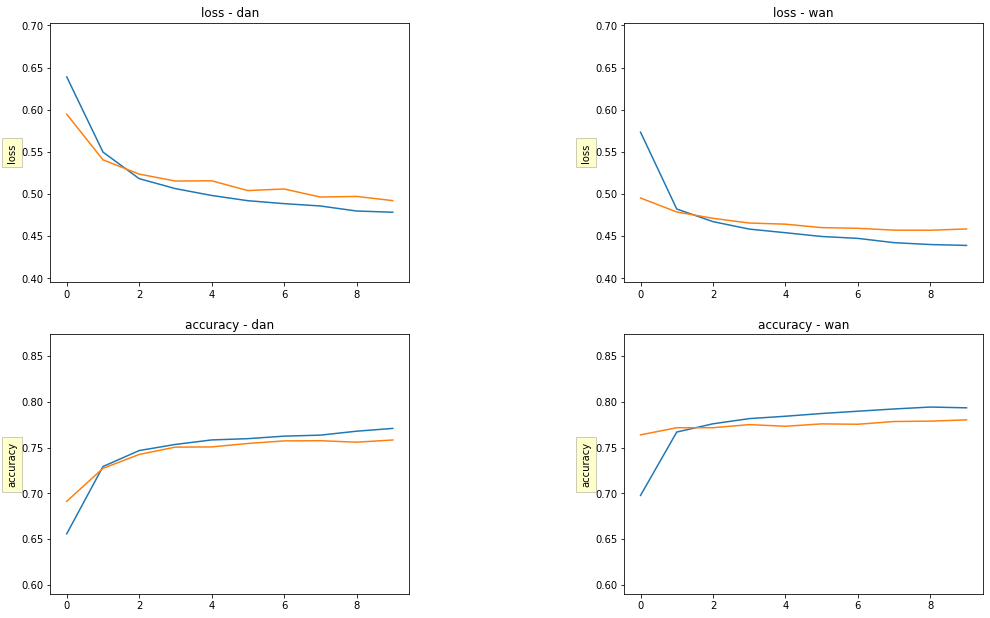

In [61]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_shuffled_history,
          wan_history, 
          model_1_name='dan',
         model_2_name='wan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Next, let us see for the wan_model which words matter most for the classification prediction and which ones did less so. How can we tell? We can look at the attention weights!

Let's look at the first training example.  We'll need to convert the input_ids back into the associated strings.

In [62]:
train_examples[0].numpy().decode('utf-8')

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

The corresponding list of input ids that are suitably formatted, i.e. with sequence length 100, are these:

In [63]:
probe_input_ids = train_input_ids[0]
print(probe_input_ids.shape)
probe_input_ids

(100,)


array([21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
       16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
       35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
         638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
       22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
       36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
       17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
        9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
       23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
       18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
       43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
       42958])

and the first 10 corresponding tokens are: 

In [64]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

In [65]:
probe_tokens = [x.decode('utf-8') for x in train_tokens[0].numpy()][:100]
probe_tokens[:10]

['This',
 'was',
 'an',
 'absolutely',
 'terrible',
 'movie.',
 "Don't",
 'be',
 'lured',
 'in']

Using only the first record in the training set, identify the **5 words** with the highest impact and the **5 words** with the lowest impact on the score, i.e., identify the 5 words with the largest and  smallest weights, respectively. (Note that multiple occurences of the same word count separately for the exercise).

HINT: You should create a list of (word/weight) pairs, and then sort by the second argument. Python's '.sort()' function may come in handy.  And make sure you decode the integer ids.

HS: just need to predict instead of fit() here

In [66]:
# 1D array (vector)
train_input_ids[0]

array([21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
       16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
       35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
         638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
       22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
       36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
       17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
        9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
       23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
       18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
       43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
       42958])

In [67]:
# 2D array
train_input_ids[:1]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958]])

In [68]:
### YOUR CODE HERE

# 'pairs' should be the variable that holds the token/weight pairs.
# HINT: You should create a list of (word/weight) pairs, 
# and then sort by the second argument. Python's '.sort()' function may come in handy. And make sure you decode the integer ids.

words = probe_tokens
weights = wan_model.predict(train_input_ids[:1])[1].ravel()

pairs = list(zip(words, weights))
pairs.sort(key=lambda x: x[1], reverse=True)
important_tokens = [i[0] for i in pairs]

print('Five Most Important Tokens\t', important_tokens[:5])
print('Five Least Important Tokens\t', important_tokens[-5:],'\n==============================================================')
### END YOUR CODE

print('most important tokens:')
print('\t', pairs[:10])
print('\nleast important tokens:')
print('\t', pairs[-10:])


# the same words becasue we have attention layer where weights a slightly differently depending on the context

Five Most Important Tokens	 ['worst', 'terrible', 'pathetic', 'pathetic', 'devoid']
Five Least Important Tokens	 ['this', 'this', 'am', 'The', 'the'] 
most important tokens:
	 [('worst', 0.11283829), ('terrible', 0.07721402), ('pathetic', 0.05390569), ('pathetic', 0.05390569), ('devoid', 0.041522477), ('ridiculous', 0.034188494), ('nothing', 0.028918073), ('emotional', 0.02378483), ('simply', 0.021523677), ('must', 0.021245498)]

least important tokens:
	 [('their', 0.0018700798), ('their', 0.0018700798), ('their', 0.0018700798), ('I', 0.0017970529), ('her', 0.00177894), ('this', 0.0017488814), ('this', 0.0017488814), ('am', 0.0017145686), ('The', 0.0016614991), ('the', 0.001273655)]


 **QUESTION:**

 2.2.2.b List the 5 most important words, with the most important first. (Again, if a word appears twice, you can include it twice.)<br>
 **['worst', 'terrible', 'pathetic', 'pathetic', 'devoid']**

 2.2.2.c List the 5 least important words in descending order. (Again, if a word appears twice, note it twice in the answers file.)<br>
 **['I', 'The', 'her', 'am', 'the']** 

### 2.3 Approaches for Training of Embeddings

**Heesuk Question:** 
- shuffle=False or True
- fixed batch_size?

Rerun the DAN Model in 3 separate configurations:


1.   embedding_initializer = 'word2vec' and retrain_embeddings=False
2.   embedding_initializer = 'word2vec' and retrain_embeddings=True
3.   embedding_initializer = 'uniform' and retrain_embeddings=True


**NOTE:** Train the model with static embeddings for 10 epochs and the ones with trainable embeddings for 3 epochs each. 

What do you observe about the effects of initializing and retraining the embedding matrix?



In [69]:
### YOUR CODE HERE
def run_dan_experiments(retrain_embeddings=False, 
                        embedding_initializer='word2vec',
                        num_epochs=10):
  dan_model_shuffled = create_dan_model(retrain_embeddings=retrain_embeddings, embedding_initializer=embedding_initializer)
  dan_shuffled_history = dan_model_shuffled.fit(sorted_training_input_ids,
                                                sorted_training_labels,
                                                validation_data=(test_input_ids, test_input_labels),
                                                shuffle=True,
                                                batch_size=32,
                                                epochs=num_epochs)
  print('\nThe highest val_accuracy: {:.5f}'.format(max(dan_shuffled_history.history['val_accuracy'])))
  return dan_shuffled_history
### END YOUR CODE

**QUESTION:**

2.3.a First, what is the highest validation accuracy that you just observed for the static model initialized with the word2vec after 10 epochs?  (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765)

In [70]:
### YOUR CODE HERE
dan_model_shuffled_1 = run_dan_experiments()
### END YOUR CODE

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6443 - accuracy: 0.6474 - val_loss: 0.5971 - val_accuracy: 0.6948
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5538 - accuracy: 0.7266 - val_loss: 0.5411 - val_accuracy: 0.7290
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5215 - accuracy: 0.7439 - val_loss: 0.5438 - val_accuracy: 0.7278
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5085 - accuracy: 0.7533 - val_loss: 0.5347 - val_accuracy: 0.7314
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5015 - accuracy: 0.7571 - val_loss: 0.5093 - val_accuracy: 0.7516
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4942 - accuracy: 0.7613 - val_loss: 0.5124 - val_accuracy: 0.7518
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4892 - accuracy: 0.7625 - val_loss: 0.5015 - val_accuracy: 0.7560
Epoch 

**QUESTION:**


2.3.b What is the highest validation accuracy that you observed for the model where you initialized with word2vec vectors but allow them to retrain for 3 epochs? (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765)

HS: may have a higher accuracy but likely to overfit when unfreeze pre-trained layers.



In [71]:
### YOUR CODE HERE
dan_model_shuffled_2 = run_dan_experiments(retrain_embeddings=True, 
                        embedding_initializer='word2vec',
                        num_epochs=3)
### END YOUR CODE

Epoch 1/3
625/625 [==============================] - 179s 286ms/step - loss: 0.4996 - accuracy: 0.7543 - val_loss: 0.4581 - val_accuracy: 0.7832
Epoch 2/3
625/625 [==============================] - 177s 283ms/step - loss: 0.3197 - accuracy: 0.8638 - val_loss: 0.4731 - val_accuracy: 0.7814
Epoch 3/3
625/625 [==============================] - 179s 286ms/step - loss: 0.2387 - accuracy: 0.9063 - val_loss: 0.5152 - val_accuracy: 0.7812

The highest val_accuracy: 0.78320


**QUESTION:**

2.3.c What is the highest validation accuracy that you observed for the model where you initialized randomly and then trained?  (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765)




In [72]:
### YOUR CODE HERE
dan_model_shuffled_3 = run_dan_experiments(retrain_embeddings=True, 
                        embedding_initializer='uniform',
                        num_epochs=3)
### END YOUR CODE

Epoch 1/3
625/625 [==============================] - 182s 289ms/step - loss: 0.5018 - accuracy: 0.7515 - val_loss: 0.4365 - val_accuracy: 0.7910
Epoch 2/3
625/625 [==============================] - 179s 287ms/step - loss: 0.3192 - accuracy: 0.8686 - val_loss: 0.4694 - val_accuracy: 0.7870
Epoch 3/3
625/625 [==============================] - 180s 288ms/step - loss: 0.2319 - accuracy: 0.9105 - val_loss: 0.5312 - val_accuracy: 0.7802

The highest val_accuracy: 0.79100



## 3. BERT-based Classification Models
real 3 inputs:
token input ids = 
masked lang model predict 
next sent prediction
attention mask: which are real tokens and which ones are padding tokens

word embeddings (some weight maxtrix)-all the tokens for the 
token type input (all zeros) or not pass it
3rd embedding: for the position. we don't pass in becasue it's trivial BERT just generate it automaocalltly
diff BERT will geenreate diff 


Now we turn to classification with BERT. We will perform classifications with various models that are based on pre-trained BERT models.


### 3.1. Basics

Let us first explore some basics of BERT. 

We've already loaded the pretrained BERT model and tokenizer that we'll use (
'bert-base-cased').

HS: Split-up words like **"glaucoma" -> "g", "##lau", "##com", "##a".**
The **pound** always means that this token ("##lau") here is **a continuation of what was there beforehand ("g")**. Each word (i.e. "g" and "##lau") has own embedding and the immediate implication is that none of these tokens individually here knows anything much about glaucoma.

Now, consider this input:



In [73]:
test_input = ['this bank is closed on Sunday', 'the steepest bank of the river is dangerous']

In [74]:
# bert_model.weights     ## = weights matrixes

In [75]:
print('Tokens_Sent2 = ', bert_tokenizer.tokenize(test_input[1]),'\n')
print('Tokens_Sent2:\n', bert_tokenizer(test_input[1]))

tokenized_sent0 = bert_tokenizer.tokenize(test_input[0])
tokenized_sent1 = bert_tokenizer.tokenize(test_input[1])
print(f'\nNum_Tokens_Sent1 = {len(tokenized_sent0)}\nNum_Tokens_Sent2 = {len(tokenized_sent1)}')

Tokens_Sent2 =  ['the', 'steep', '##est', 'bank', 'of', 'the', 'river', 'is', 'dangerous'] 

Tokens_Sent2:
 {'input_ids': [101, 1103, 9458, 2556, 3085, 1104, 1103, 2186, 1110, 4249, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Num_Tokens_Sent1 = 6
Num_Tokens_Sent2 = 9


Now apply the BERT tokenizer to tokenize it:

In [76]:
tokenized_input = bert_tokenizer(test_input, 
                                 max_length=12,
                                 truncation=True,
                                 padding='max_length', 
                                 return_tensors='tf')

tokenized_input

{'input_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[ 101, 1142, 3085, 1110, 1804, 1113, 3625,  102,    0,    0,    0,
           0],
       [ 101, 1103, 9458, 2556, 3085, 1104, 1103, 2186, 1110, 4249,  102,
           0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=int32)>}

 **QUESTION:** 
 
 3.1.a  Why do the attention_masks have 4 and 1 zeros, respectively?  Choose the correct one and enter it in the answers file.; **The 2nd one is correct.**

  *  For the first example the last four tokens belong to a different segment. For the second one it is only the last token.

  *  **For the first example 4 positions are padded while for the second one it is only one.**

------


Next, let us look at the BERT outputs for these 2 sentences:

In [77]:
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# bert_model = TFBertModel.from_pretrained('bert-base-cased')

Let's look at the output of the BERT model. If we pass the input (= **tokenized_input** that contains, input_ids, token_type_ids, and attention mask) that we got from the tokenizer directly to the BERT model, we get the two BERT outputs.<br>
```bert_output = bert_output[0] and bert_output[1] = token-level output (last_hidden_state_output) and pooler layer output```
- **bert_output[0] = token-level output = last_hidden_state_output:** The <u>full sequence of contextualized embeddings</u>. Here we're <u>not even bothering with their classification layer </u> that they used for mask language model tasks because that's not what we're going to use it for. So the output we get from the model we've loaded is the **output from the last hidden layer.**
- **bert_output[1] = pooler layer output**: Not a sequence of contextualized embeddings. It's just <u>a single vector for each example for each whole text (one vector for the whole text) and an **additional transformation of the CLS token** because the intention for BERT was to use CLS token as a representation for the whole text</u> if you are going to just do overall <u>text classification</u>.
  - In the HW2, you will instead use the **actual CLS token output** that is the **1st vector in the sequence** that comes out - look at the output of the following question where says **TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(2, 12, 768), dtype=float32, numpy=**<br>

    ```array([[[ 0.39452162,  0.04198498,  0.06480392, ...,  0.05045465, 0.22358865,  0.24238195],```
  - Then, the **pooler_output** is that same vector but it's been **transformed one more time**.




In [85]:
### YOUR CODE HERE

# bert_output = bert_model(tokenized_input, output_hidden_states=True)
bert_output = bert_model(tokenized_input)

# have 2 sentences coming in, each sentence has 12 tokens (max_length=12; start with CLS token and end with SEP token so "actual num of tokens for each sentence" is 10), 
# so "for each sentence position" we have a 768 dimentional embedding, because this is the "BERT base model" with the embedding dimension of 768.
print('Shape of the 1st BERT output (token-level output = last_hidden_state_output): \t', bert_output[0].shape)  
print(f'\tnum_sentence: {bert_output[0].shape[0]}\n\tnum_tokens_in_each_sentence: {bert_output[0].shape[1]}\n\tembedding_size_for_the_BERT_base_model: {bert_output[0].shape[2]}')   
print('\nShape of the 2nd BERT output (pooler layer output): \t', bert_output[1].shape, '\n')

bert_output

### END YOUR CODE

# how many outputs object - dict how many keys_values 
# take a pass in two ex sent and then tolkenize pass the tokenized words into bert model and feed out the output.

Shape of the 1st BERT output (token-level output = last_hidden_state_output): 	 (2, 12, 768)
	num_sentence: 2
	num_tokens_in_each_sentence: 12
	embedding_size_for_the_BERT_base_model: 768

Shape of the 2nd BERT output (pooler layer output): 	 (2, 768) 



TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(2, 12, 768), dtype=float32, numpy=
array([[[ 0.39452162,  0.04198498,  0.06480392, ...,  0.05045465,
          0.22358865,  0.24238195],
        [-0.09458938,  0.06673858, -0.03607508, ...,  0.21925777,
         -0.06967178,  0.7444841 ],
        [ 0.00561032,  0.31316498, -0.17982729, ...,  0.19563246,
         -0.10614744,  0.47773576],
        ...,
        [ 0.22268784, -0.11558574,  0.15854378, ...,  0.300253  ,
          0.01634064,  0.5133398 ],
        [ 0.31638402, -0.10986975,  0.23661816, ...,  0.10924117,
         -0.14340344,  0.32835424],
        [ 0.34834048, -0.10076536,  0.26903212, ...,  0.1270758 ,
         -0.18430144,  0.26176217]],

       [[ 0.44506383,  0.22264977, -0.09972473, ..., -0.23736244,
          0.12722534,  0.07778197],
        [ 0.07407635, -0.3180579 , -0.11924689, ..., -0.06680152,
         -0.3061709 ,  0.46923548],
        [ 0.314581  ,  0.62658757,  0.00606293, ..

 **QUESTION:** 
 
 3.1.b How many outputs are there?

 Enter your code below.

In [ ]:
### YOUR CODE HERE

#b. -> print it out
print(len(bert_output))

### END YOUR CODE

2


**QUESTION:** 

 3.1.c Which output do we need to use to get token-level embeddings?

 * **the first** (correct)
 
 * the second 
 
 Put your answer in the answers file.

**QUESTION:** 

 3.1.d In the tokenized input, which input_id number (i.e. the vocabulary id) corresponds to 'bank' in the two sentences? ('bert_tokenizer.tokenize()' may come in handy.. and don't forget the CLS token! )

In [ ]:
# test_input = ['this bank is closed on Sunday', 'the steepest bank of the river is dangerous']
print(bert_tokenizer.tokenize(test_input[0]))
print(bert_tokenizer.tokenize(test_input[1]))

['this', 'bank', 'is', 'closed', 'on', 'Sunday']
['the', 'steep', '##est', 'bank', 'of', 'the', 'river', 'is', 'dangerous']


In [ ]:
print(bert_tokenizer(test_input[0]))
print(bert_tokenizer(test_input[1]))
print("\nInput_id for 'bank' in the 1st sentence: ", bert_tokenizer(test_input[0])['input_ids'][2])   # bank at index 3 in the 2nd sentence 
print("Input_id for 'bank' in the 2nd sentence: ", bert_tokenizer(test_input[1])['input_ids'][4])   # bank at index 3 in the 2nd sentence 

{'input_ids': [101, 1142, 3085, 1110, 1804, 1113, 3625, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [101, 1103, 9458, 2556, 3085, 1104, 1103, 2186, 1110, 4249, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Input_id for 'bank' in the 1st sentence:  3085
Input_id for 'bank' in the 2nd sentence:  3085


**QUESTION:** 

 3.1.e In the array of tokens, which position index number corresponds to 'bank' in the first sentence? ('bert_tokenizer.tokenize()' may come in handy.. and don't forget the CLS token! )

In [ ]:
tokens_sent1 = bert_tokenizer.tokenize(test_input[0])
tokens_sent2 = bert_tokenizer.tokenize(test_input[1])
print(f'tokens_sent1: {tokens_sent1}\ntokens_sent2: {tokens_sent2}')

tokens_sent1: ['this', 'bank', 'is', 'closed', 'on', 'Sunday']
tokens_sent2: ['the', 'steep', '##est', 'bank', 'of', 'the', 'river', 'is', 'dangerous']


In [ ]:
### YOUR CODE HERE

#d/e. -> Look at tokens generated by the bert tokenizer for the first example

print('Position Index for "bank" in the 1st sentence: ', tokens_sent1.index('bank')+1)   # CLS token at index 0

### END YOUR CODE

Position Index for "bank" in the 1st sentence:  2


**QUESTION:** 

3.1.f Which array position index number corresponds to 'bank' in the second sentence?

In [ ]:
### YOUR CODE HERE

#f. -> Look at tokenization for the second example

print('Position Index for "bank" in the 2nd sentence: ', tokens_sent2.index('bank')+1)   # CLS token at index 0

### END YOUR CODE

Position Index for "bank" in the 2nd sentence:  4


**QUESTION:**

 3.1.g What is the cosine similarity between the BERT embeddings for the two occurences of 'bank' in the two sentences?

In [ ]:
### YOUR CODE HERE

#g.  -> get the vectors and calculate cosine similarity between the two 'bank' BERT embedddings
# take 1st output (=token-level output) and take the 1st sentence and 3rd token (at index 2 -> CLS token at index 0)

from transformers.models.conditional_detr.image_processing_conditional_detr import defaultdict
import pandas as pd

def cosine_similarities(inputs):
  cosine_sim_dict = defaultdict(lambda: defaultdict(str))
  names = []

  for name1, vec1 in inputs.items():
    names.append(name1)
    cosine_sim_dict[name1] = []
        
    for name2, vec2 in inputs.items():
        cosine_sim_dict[name1].append(str(np.dot(vec1, vec2)/np.sqrt(np.dot(vec1, vec1) * np.dot(vec2, vec2)))[:8])
    
  formatted_dict = {**{'':names}, **cosine_sim_dict}
  formatted_out = pd.DataFrame(formatted_dict).to_string(index=True)
  return formatted_out

bank_cosine_sim = {'bank_sent_1':bert_output[0][0,2],
                   'bank_sent_2':bert_output[0][1,4]}   

print(cosine_similarities(bank_cosine_sim))

### END YOUR CODE
# 0.74783

               bank_sent_1 bank_sent_2
0  bank_sent_1         1.0    0.747830
1  bank_sent_2    0.747830         1.0


It shows that the cosine similarity score between **bank in sentence 1** and **bank in sentence 2** is **0.74**, which is significantly close in context.

**QUESTION:**

3.1.h How does this relate to the cosine similarity of 'this' (in sentence 1) and the first 'the' (in sentence 2). Compute their cosine similarity.


In [ ]:
### YOUR CODE HERE

#h.  -> get the vectors and calculate cosine similarity
# may be just this and the

# tokens_cosine_sim = {'bank_sent_1':bert_output[0][0,2],
#                     'bank_sent_2':bert_output[0][1,4],      #  'bank_sent_2':bert_output[0][1,4]
#                     'this_sent_1':bert_output[0][0,1],
#                     'the_sent_2':bert_output[0][1,1]}

tokens_cosine_sim = {'this_sent_1':bert_output[0][0,1],
                    'the_sent_2':bert_output[0][1,1]}

print(cosine_similarities(tokens_cosine_sim))

### END YOUR CODE

               this_sent_1 the_sent_2
0  this_sent_1         1.0   0.811026
1   the_sent_2    0.811026        1.0


The cosine similarity **(0.81)** of **this in sentence 1** is the largest with **the in sentence 2**, followed by the similarity of **0.74** between **bank in sentence 1** and **bank in sentence 2**.

### 3.2 CLS-Token-based Classification 

In the live session we discussed classification with BERT using the pooled token. We now will do the same but extract the [CLS] token output for each example and use that for classification purposes.

Consult the model from the live session and change accordingly. Make sure the BERT model is fully trainable.

**HINT:**
You will want to extract the output of the [CLS] token from the BERT output similarly to what we did above to get the output for 'bank', etc.

cls_token = **bert_out[0][:, 0, :]** means that you want **[CLS] tokens** from all the input sentences (token-level output) with the given dimensional embeddings (768 in this case since our model is BERT base) for each CLS position.
- ```:```  means "all the given input sentences" from the token-level output (last_hidden_state_layer)
- ```0```  means the 1st position of the tokens at each sentence (CLS token at index 0, 1st actual token at index 1.... SEP at the last index)
- ```:``` with the given embedding dimension of 768


In [ ]:
def create_bert_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output (= Pooler Output) for classification purposes.
    """

    ### YOUR CODE HERE
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    # pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]    # give us a raw CLS tokens

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    ### END YOUR CODE
    
    return classification_model

Now create the model and train for 2 epochs. Use batch size 8 and the appropriate validation/test set. (We don't make a distinction here between validation and test although we might in other contexts.)


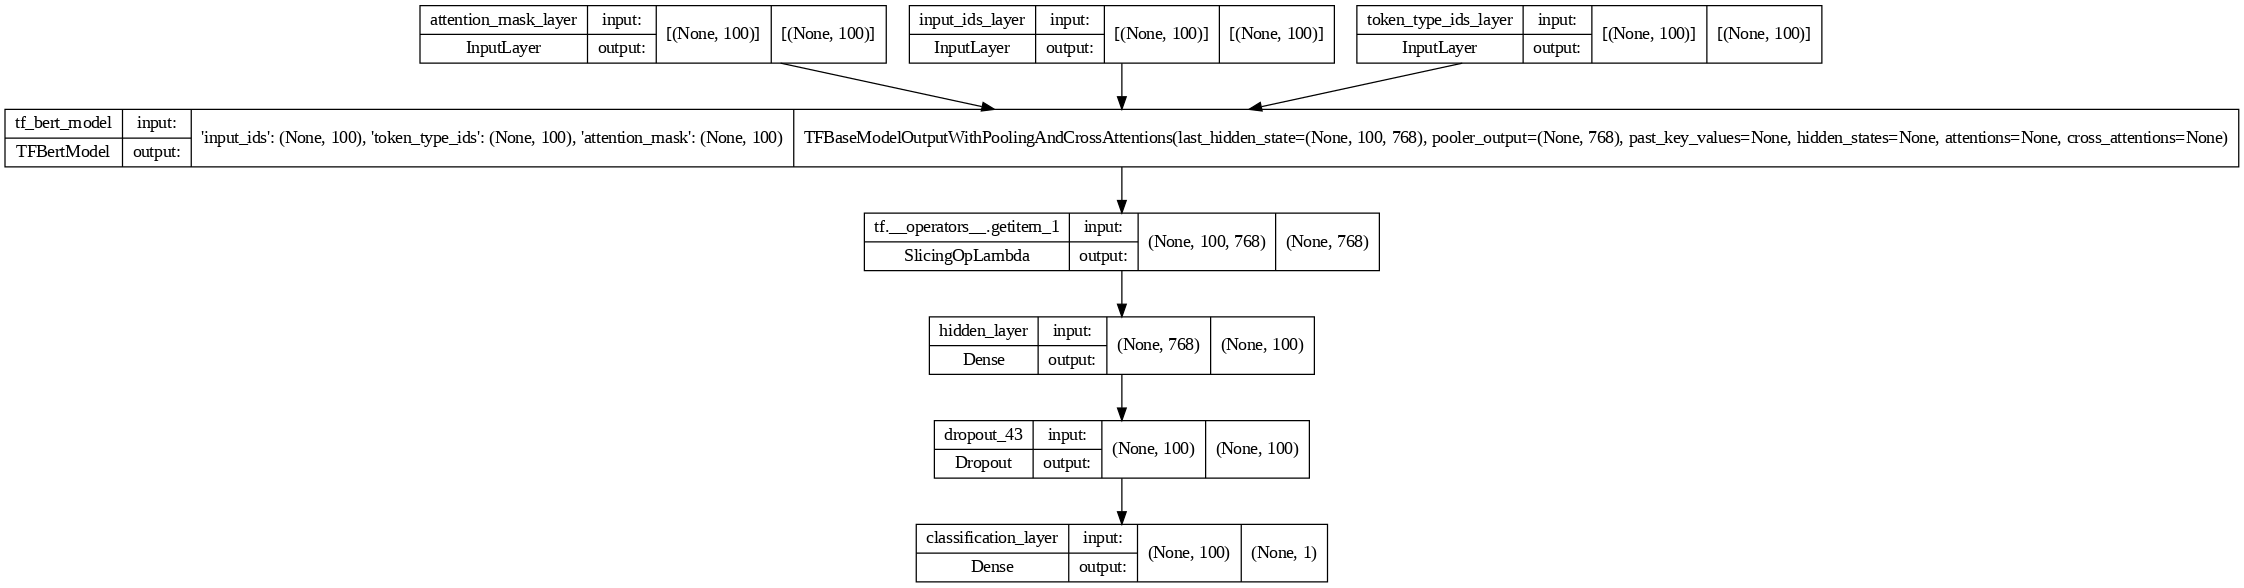

In [ ]:
bert_cls_model = create_bert_cls_model()
keras.utils.plot_model(bert_cls_model, show_shapes=True, dpi=90)
# keras.utils.plot_model(bert_cls_model)

In [ ]:
### YOUR CODE HERE
bert_classification_model_history = bert_cls_model.fit(
    [bert_train_tokenized.input_ids, bert_train_tokenized.token_type_ids, bert_train_tokenized.attention_mask],
    # bert_train_inputs,
    bert_train_labels,
    # validation_data=([bert_test_tokenized.input_ids, bert_test_tokenized.token_type_ids, bert_test_tokenized.attention_mask], bert_test_labels),
    validation_data=(bert_test_inputs, bert_test_labels),
    batch_size=8,
    epochs=2)

### END YOUR CODE

Epoch 1/2


2500/2500 [==============================] - 527s 206ms/step - loss: 0.4412 - accuracy: 0.7954 - val_loss: 0.4157 - val_accuracy: 0.8220
Epoch 2/2
2500/2500 [==============================] - 507s 203ms/step - loss: 0.3021 - accuracy: 0.8752 - val_loss: 0.4012 - val_accuracy: 0.8128


 **QUESTION:** 
 
 3.2.a What is the highest validation accuracy that you observed for the [CLS]-classification model after training for 2 epochs? (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765): **0.8336**


 

### 3.3 Classification by Averaging the BERT outputs

Instead of using only the output vector for the [CLS] token, we will now average the output vectors from BERT for all of the tokens in the full sequence.

**HINT:**
You will want to get the full sequence of token output vectors from the BERT model and then apply an average across the tokens. You may want to use:

```
tf.math.reduce_mean()
```
but you can also do it in other ways.



In [ ]:
def create_bert_avg_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the average of the BERT output tokens
    """

    ### YOUR CODE HERE
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)
    all_tokens = bert_out[0]                                     # shape: (None, 100, 768); token level vectors
    avg_cls_token = tf.math.reduce_mean(all_tokens, axis=1)      # shape: (None, 768); axis=1 (column=width)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(avg_cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),          # A 'sigmoid' activation layer turns the output "logit" into a value, 0-1 
                                 metrics='accuracy')    
    
    ### END YOUR CODE

    return classification_model

In [ ]:
bert_avg_model = create_bert_avg_model()
bert_avg_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                            

Now create the model and train for 2 epochs. Use batch size 8 and the appropriate validation/test set. (We again don't make a distinction here.)  Remember that all layers of the BERT model should be trainable.

In [ ]:
### YOUR CODE HERE
bert_avg_model_history = bert_avg_model.fit(
    # [bert_train_tokenized.input_ids, bert_train_tokenized.token_type_ids, bert_train_tokenized.attention_mask],
    bert_train_inputs,
    bert_train_labels,
    # validation_data=([bert_test_tokenized.input_ids, bert_test_tokenized.token_type_ids, bert_test_tokenized.attention_mask], bert_test_labels),
    validation_data=(bert_test_inputs, bert_test_labels),
    batch_size=8,
    epochs=2)

### END YOUR CODE

Epoch 1/2


2500/2500 [==============================] - 524s 206ms/step - loss: 0.1912 - accuracy: 0.9276 - val_loss: 0.5725 - val_accuracy: 0.8266
Epoch 2/2
2500/2500 [==============================] - 518s 207ms/step - loss: 0.1130 - accuracy: 0.9613 - val_loss: 0.5352 - val_accuracy: 0.8188


 **QUESTION:** 
 
 3.3.a What is the highest validation accuracy that you observed for the BERT-averaging-classification model after training for 2 epochs? (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765); **0.8290**


 

### 3.4 Adding a CNN on top of BERT

Can we also combine advanced architectures? Absolutely! In the end we are dealing with tensors and it does not matter whether they are coming from static word2vec embeddings or context-based BERT embeddings. (Whether we want to is another question, but let's try it here.)


**HINT:**
You should appropriately stitch together the BERT-based components and the CNN components from the lesson notebook. Remember that BERT provides a sequence of contextualized token embeddings as its main output, and a CNN takes a sequence of vectors as input.

Use the provided hyperparameters for CNN filter sizes and numbers of filters. Keep the same hyperparameters for the rest of the model, including a dropout layer and dense layer after the CNN, with the provided dropout rate and hidden_size. Again make sure the BERT model is trainable.

[Max Pooling vs Global Max Pooling](https://www.researchgate.net/figure/The-difference-of-max-pooling-and-global-max-pooling_fig4_338079465)

- The **max-pooling layer** gave the
largest value in a certain subarea as an output, while the **global max-pooling** did this in the whole area.
Figure 4 shows the difference.
-  The **max-pooling layer** says that we want to take the max value from a given output and propagate (전파하다. 보급하다) only the max value.

[from_logits=False](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- **from_logits=False** by default
- Use this cross-entropy loss for binary (0 or 1) classification applications. The loss function requires the following inputs: <br>
**y_true (true label):** This is either 0 or 1.
y_pred (predicted value): This is the model's prediction, i.e, a single floating-point value which either represents a logit, (i.e, value in **[-inf, inf]** when **from_logits=True**) or a probability (i.e, value in **[0., 1.]** when **from_logits=False**).

Recommended Usage: (set **from_logits=True**)

[Using a softmax or sigmoid in the final layer in the network](https://stackoverflow.com/questions/55929401/how-to-specify-model-compile-for-binary-crossentropy-activation-sigmoid-and-act), you do NOT need **from_logits=True**. Softmax and sigmoid output normalized values between **[0, 1]**, which are considered **probabilities** in this context.



In [ ]:
def create_bert_cnn_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [2, 3, 4, 5],
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=0.00005):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    ### YOUR CODE HERE
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)
    all_tokens = bert_out[0] 

    # Convoluation Layers: defined by input size, num of filters/feature maps to output and a kernal size.
    #   The output of these layers will go through a ReLu activation function and global max pooling layer (average embeddings)
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):          # kernel is the weights that you are tuning (not hand coding in)
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(all_tokens)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dense(hidden_size, activation='relu')(conv_output)  
    last_hidden_output = keras.layers.Dropout(rate=dropout)(last_hidden_output)

    # last_hidden_output = keras.layers.Dense(hidden_size, activation='relu')(last_hidden_output)    
    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    classification_model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=cnn_prediction)

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),          # UPDATED FROM from_logits=False TO from_logits=True (default)
                                 metrics='accuracy')    
    ### END YOUR CODE
    
    return classification_model

# dropout is usually last right before the output layer (removing random # of nodes preventing overfitting)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                            

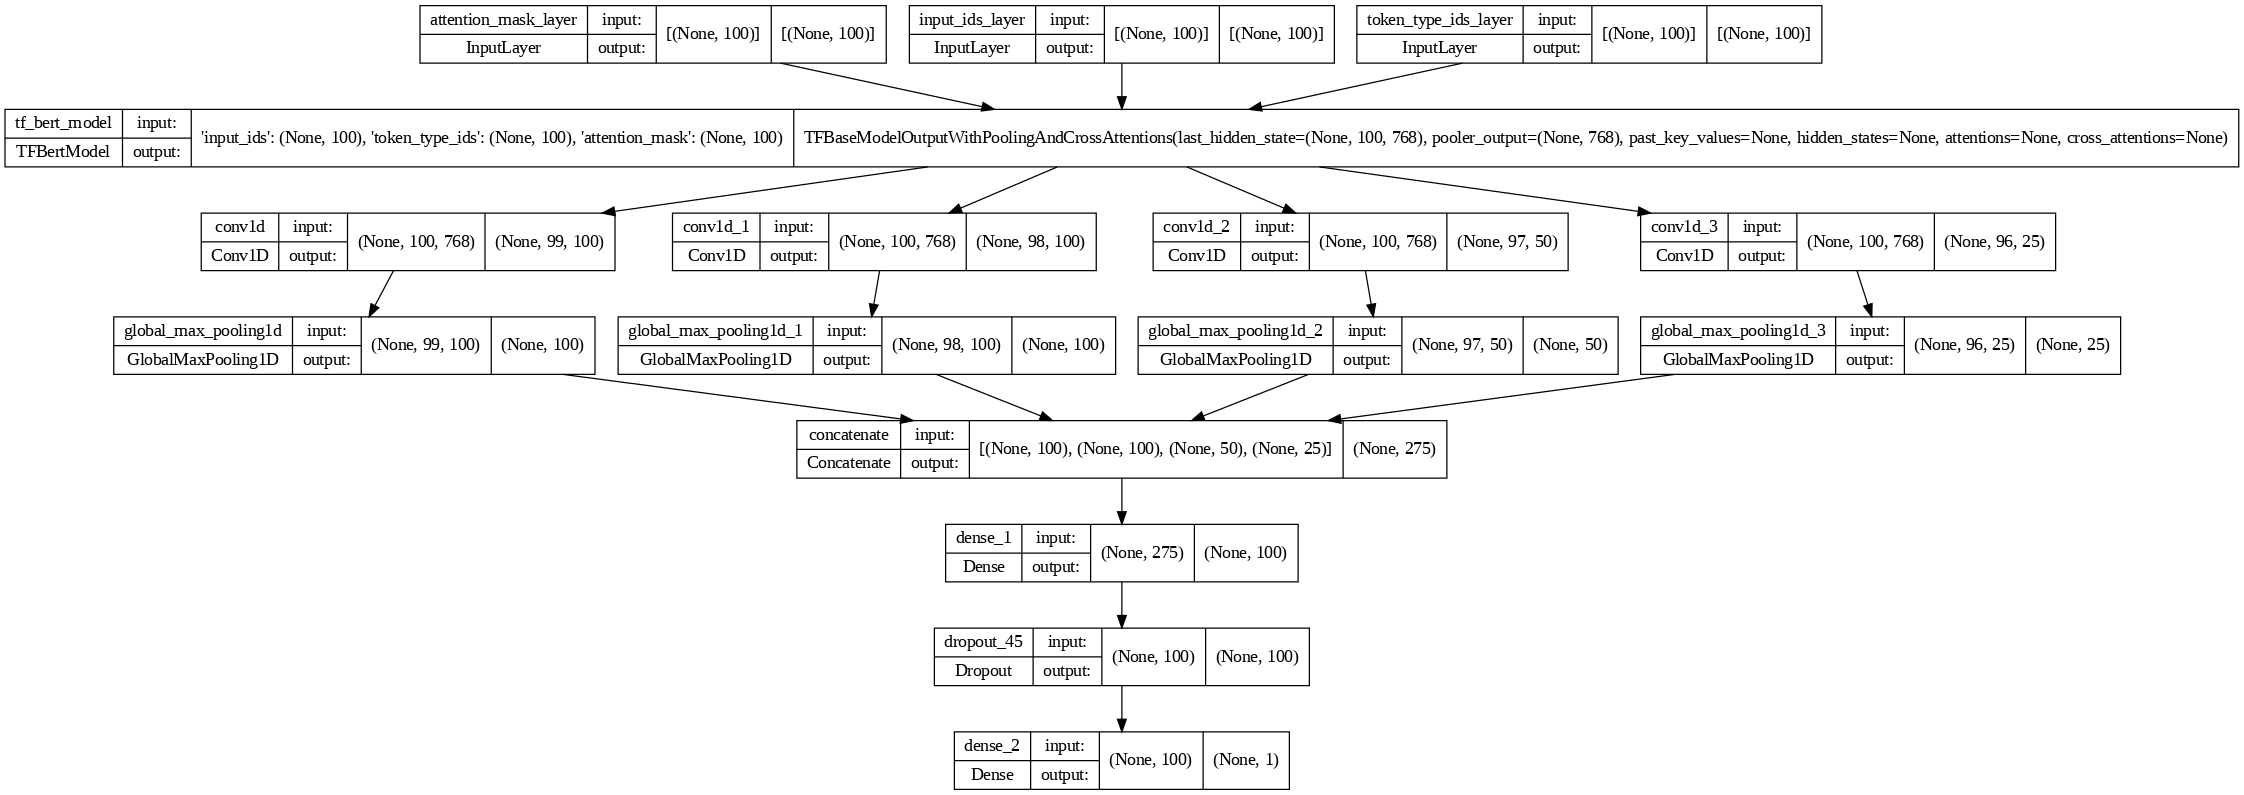

In [ ]:
bert_cnn_model = create_bert_cnn_model()
bert_cnn_model.summary()
keras.utils.plot_model(bert_cnn_model, show_shapes=True, dpi=90)

Train this model for 2 epochs as well with mini-batch size of 8:

In [ ]:
### YOUR CODE HERE

bert_cnn_model_history = bert_cnn_model.fit(
    bert_train_inputs,
    bert_train_labels,
    # validation_data=([bert_test_tokenized.input_ids, bert_test_tokenized.token_type_ids, bert_test_tokenized.attention_mask], bert_test_labels),
    validation_data=(bert_test_inputs, bert_test_labels),
    batch_size=8,
    epochs=2)

### END YOUR CODE


Epoch 1/2


2500/2500 [==============================] - 551s 211ms/step - loss: 0.0936 - accuracy: 0.9687 - val_loss: 0.5442 - val_accuracy: 0.8200
Epoch 2/2
2500/2500 [==============================] - 528s 211ms/step - loss: 0.0677 - accuracy: 0.9791 - val_loss: 0.5665 - val_accuracy: 0.8088


 **QUESTION:** 
 
3.4.a What is the highest validation accuracy that you observed for the BERT-CNN-classification model after 2 epochs?  (Copy and paste the decimal value for the highest validation accuracy, e.g. a number like 0.5678 or 0.8765): **0.8184**


# That's It! 
## Congratulations... You are done! 
## We hope you learned a ton!